<a href="https://colab.research.google.com/github/VinayNagamallaD9/SmartApplicationPerformanceMonitoring-Auto-Scaling/blob/main/Traffic_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#Importing Libraries
import pandas as pd
import numpy as np

In [13]:
# Generation of realistic fake traffic data
data = {
    'timestamp': pd.date_range(start="2023-01-01", periods=500, freq="H"),
    'latitude': np.random.uniform(12.85, 13.15, 500),  # Bangalore coordinates
    'longitude': np.random.uniform(77.45, 77.75, 500),
    'vehicle_count': np.random.randint(20, 300, 500),
    'avg_speed': np.random.uniform(5, 60, 500),
    'congestion_level': np.random.randint(0, 100, 500)
}
df = pd.DataFrame(data)
df.to_csv("traffic_data.csv", index=False)
print("Sample dataset created: traffic_data.csv")


Sample dataset created: traffic_data.csv


/tmp/ipython-input-13-957219171.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'timestamp': pd.date_range(start="2023-01-01", periods=500, freq="H"),


In [14]:
import pandas as pd
df = pd.read_csv("traffic_data.csv")
print(df.head())  # Show first 5 rows
print("\nData columns:", df.columns.tolist())

             timestamp   latitude  longitude  vehicle_count  avg_speed  \
0  2023-01-01 00:00:00  13.090324  77.725750             72  44.459948   
1  2023-01-01 01:00:00  12.962340  77.651377            292  38.113610   
2  2023-01-01 02:00:00  12.911417  77.621946            137  54.566256   
3  2023-01-01 03:00:00  13.104498  77.714068             52  36.076436   
4  2023-01-01 04:00:00  13.085907  77.558223            120  42.081741   

   congestion_level  
0                60  
1                80  
2                95  
3                85  
4                35  

Data columns: ['timestamp', 'latitude', 'longitude', 'vehicle_count', 'avg_speed', 'congestion_level']


In [15]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [16]:
# Load your generated data
df = pd.read_csv("traffic_data.csv")


# Convert timestamp to hour-of-day
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour

# See worst congestion hours
worst_hours = df.groupby('hour')['congestion_level'].mean().sort_values(ascending=False)
print("Worst Traffic Hours:\n", worst_hours.head(3))


conn = sqlite3.connect("traffic.db")
df.to_sql("traffic_data", conn, if_exists="replace", index=False)

Worst Traffic Hours:
 hour
6     59.619048
2     58.857143
10    58.285714
Name: congestion_level, dtype: float64


500

In [17]:
# Example SQL query: Find high-congestion locations
high_congestion = pd.read_sql("""
    SELECT latitude, longitude, AVG(congestion_level) as avg_congestion
    FROM traffic_data
    GROUP BY latitude, longitude
    HAVING avg_congestion > 70
    ORDER BY avg_congestion DESC
""", conn)
print("\nHigh Congestion Areas:\n", high_congestion.head())


High Congestion Areas:
     latitude  longitude  avg_congestion
0  12.928614  77.661069            99.0
1  12.972836  77.707981            99.0
2  13.008904  77.624178            99.0
3  13.046358  77.512454            99.0
4  13.082109  77.583873            99.0


In [21]:
# Prepare features
X = df[['vehicle_count', 'avg_speed', 'hour']]
y = df['congestion_level']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train model
model = RandomForestRegressor()
model.fit(X_train, y_train)
# print("\nModel Accuracy:", model.score(X_test, y_test))

RandomForestRegressor()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Predicted Congestion at 5PM: 60.0/100


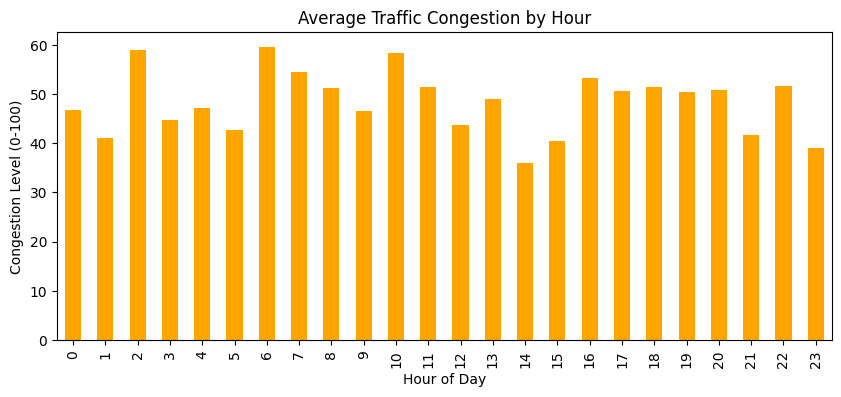

In [19]:
# Predict for new scenario: 200 cars, speed=25km/h at 5PM
prediction = model.predict([[200, 25, 17]])[0]
print(f"\nPredicted Congestion at 5PM: {prediction:.1f}/100")


# Plot congestion by hour
plt.figure(figsize=(10,4))
df.groupby('hour')['congestion_level'].mean().plot(kind='bar', color='orange')
plt.title("Average Traffic Congestion by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Congestion Level (0-100)")
plt.show()

In [22]:
# Add interactive map
!pip install folium
import folium

# Create base map
map = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)

# Add congestion markers
for _, row in df.sample(50).iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['congestion_level']/20,
        color='red' if row['congestion_level'] > 50 else 'green',
        popup=f"Congestion: {row['congestion_level']}%"
    ).add_to(map)

map